Epoch [1/50] - Train Loss: 0.301483, Test Loss: 0.169391
Epoch [2/50] - Train Loss: 0.030632, Test Loss: 0.033059
Epoch [3/50] - Train Loss: 0.015140, Test Loss: 0.009972
Epoch [4/50] - Train Loss: 0.010197, Test Loss: 0.004030
Epoch [5/50] - Train Loss: 0.007322, Test Loss: 0.005165
Epoch [6/50] - Train Loss: 0.005429, Test Loss: 0.008892
Epoch [7/50] - Train Loss: 0.004201, Test Loss: 0.010589
Epoch [8/50] - Train Loss: 0.003203, Test Loss: 0.009036
Epoch [9/50] - Train Loss: 0.002250, Test Loss: 0.005970
Epoch [10/50] - Train Loss: 0.001372, Test Loss: 0.003830
Epoch [11/50] - Train Loss: 0.000758, Test Loss: 0.001890
Epoch [12/50] - Train Loss: 0.000459, Test Loss: 0.001059
Epoch [13/50] - Train Loss: 0.000364, Test Loss: 0.000796
Epoch [14/50] - Train Loss: 0.000323, Test Loss: 0.000684
Epoch [15/50] - Train Loss: 0.000300, Test Loss: 0.000686
Epoch [16/50] - Train Loss: 0.000284, Test Loss: 0.000555
Epoch [17/50] - Train Loss: 0.000272, Test Loss: 0.000513
Epoch [18/50] - Train L

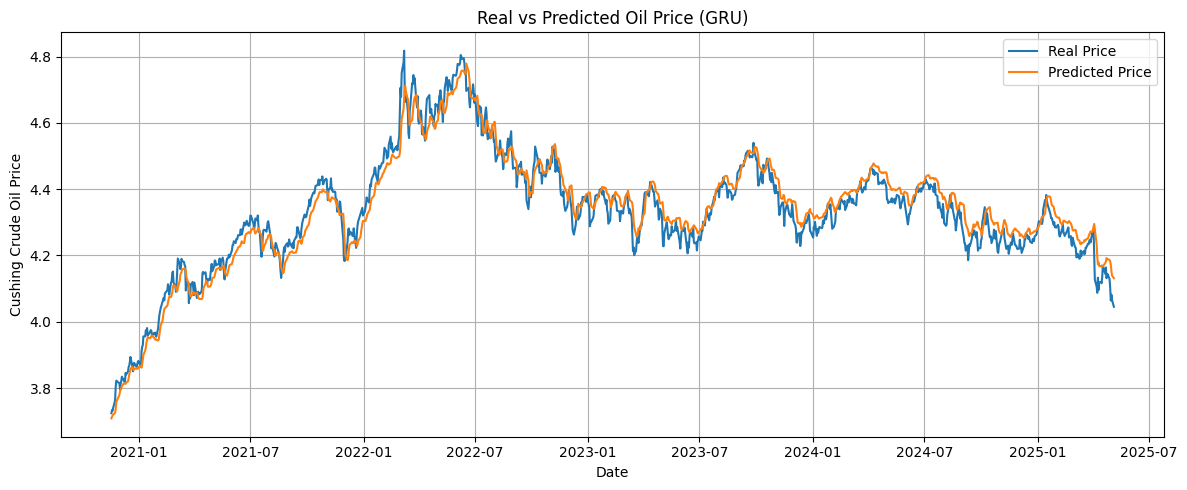

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('compiled_dataset.csv', parse_dates=['Date'])

features = [
    "Date",
    'dow_jones_adj_close_price',
    'nasdaq_adj_close_price',
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'treasury_1_year_rate',
    'breakeven_inflation_5_year_rate',
    'bank_prime_loan_rate',
    'federal_funds_rate',
]

target = 'cushing_crude_oil_price'

data = df[features + [target]].copy()
data = data.sort_values('Date').reset_index(drop=True)

feature_cols = [
    'dow_jones_adj_close_price',
    'nasdaq_adj_close_price',
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'treasury_1_year_rate',
    'breakeven_inflation_5_year_rate',
    'bank_prime_loan_rate',
    'federal_funds_rate',
    'cushing_crude_oil_price',
]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_values = data[feature_cols].values
target_values = data[[target]].values

scaled_features = feature_scaler.fit_transform(features_values)
scaled_target = target_scaler.fit_transform(target_values)

dates = data['Date'].values

def create_sequences(features_arr, target_arr, lookback=30):
    X_list = []
    y_list = []
    for i in range(lookback, len(features_arr)):
        X_list.append(features_arr[i - lookback:i])
        y_list.append(target_arr[i])
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

lookback = 30
X, y = create_sequences(scaled_features, scaled_target, lookback=lookback)
sample_dates = dates[lookback:]

train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

dates_train = sample_dates[:train_size]
dates_test = sample_dates[train_size:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(GRURegressor, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size = X_train.shape[-1]
hidden_size = 32
num_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRURegressor(input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item() * batch_X.size(0)
    test_loss /= len(test_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.6f}, Test Loss: {test_loss:.6f}")

checkpoint = {
    "model_state_dict": model.state_dict(),
    "feature_scaler": feature_scaler,
    "target_scaler": target_scaler,
    "lookback": lookback,
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
}
torch.save(checkpoint, "gru_oil_price_checkpoint.pth")
print("Checkpoint saved to gru_oil_price_checkpoint.pth")

model.eval()
with torch.no_grad():
    X_test_t = X_test_t.to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_real = target_scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)

print("Test MAE :", mae)
print("Test RMSE:", rmse)
print("Test R^2 :", r2)

plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test_real.flatten(), label="Real Price")
plt.plot(dates_test, y_pred.flatten(), label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Cushing Crude Oil Price")
plt.title("Real vs Predicted Oil Price (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
